# Supervised Machine Learning - Data Classification Demo

This project aims to analyze and classify a real network traffic data set to detect malicious/benign traffic records. It compares the performance of various Machine Learning algorithms and tunes the best-performing model to maintain the highest accuracy and lowest False Negative metrics.

The dataset used in this demo is [CTU-IoT-Malware-Capture-34-1](https://mcfp.felk.cvut.cz/publicDatasets/IoT-23-Dataset/IndividualScenarios/CTU-IoT-Malware-Capture-34-1/bro/), it is part of [Aposemat IoT-23 dataset](https://www.stratosphereips.org/datasets-iot23) (A labeled dataset with malicious and benign IoT network traffic).

# 1. INITIALIZATION

In [1]:
#importing required libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import ipaddress
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#set display options
pd.set_option('display.max_columns', None)

## 2. LOADING DATASET FILE

### Reading dataset file into DataFrame

In [2]:
#initialize required variables to read from the data file
data_file_location = "data\\raw\\"
data_file_name = "conn.log.labeled"

#column names are included in the file in a commented line, so we need to read the corresponding line separately and remove the first description word.
data_columns = pd.read_csv(data_file_location + data_file_name, sep='\t', skiprows=6, nrows=1, header=None).iloc[0][1:]

#read the actual dataset
data_df = pd.read_csv(data_file_location + data_file_name, sep='\t', comment="#", header=None)

#set column names
data_df.columns = data_columns

### Exploring dataset summary and statistics

In [3]:
#check dataset shape
data_df.shape

(23145, 21)

In [4]:
#check dataset head
data_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,- Benign -
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,- Benign -
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,- Benign -
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,- Benign -
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,- Benign -


- We notice here that the last column contains several values, this is due to unmatched delimiter in the original dataset file. We will fix it later on during the data cleaning phase.
- We also notice some fields with '-', which means the field is unset according to the dataset documentation. This will be also handled when fixing missing values.

In [5]:
#check dataset summary
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ts                                       23145 non-null  float64
 1   uid                                      23145 non-null  object 
 2   id.orig_h                                23145 non-null  object 
 3   id.orig_p                                23145 non-null  int64  
 4   id.resp_h                                23145 non-null  object 
 5   id.resp_p                                23145 non-null  int64  
 6   proto                                    23145 non-null  object 
 7   service                                  23145 non-null  object 
 8   duration                                 23145 non-null  object 
 9   orig_bytes                               23145 non-null  object 
 10  resp_bytes                               23145

- This summary tells there is no missing values which is not accurate (due to the unset fields with '-' values).
- Some numerical fields are misidentified as object (string) which will be fixed later as well.

# 3. DATA CLEANING AND PREPROCESSING

### Fixing combined column
The last columns in the dataset contains three separate values and needs to be unpacked into three corresponding columns. This is due to unmatched separators in the original data file.

In [6]:
#split the last combined column into three ones
tunnel_parents_column = data_df.iloc[:,-1].apply(lambda x: x.split()[0])
label_column = data_df.iloc[:,-1].apply(lambda x: x.split()[1])
detailed_label_column = data_df.iloc[:,-1].apply(lambda x: x.split()[2])

In [7]:
#drop the combined column
data_df.drop(["tunnel_parents   label   detailed-label"], axis=1, inplace=True)

In [8]:
#add new individual columns to the dataset
data_df["tunnel_parents"] = tunnel_parents_column
data_df["label"] = label_column
data_df["detailed_label"] = detailed_label_column

In [9]:
#check the dataset
data_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,-,Benign,-
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-


### Drop irrelevant columns
Drop extra columns that don't contribute to the data analysis and predictions (ex. ids, columns with only unique values, columns with just one value, ...).

In [10]:
#check the number of unique values in each column
data_df.nunique().sort_values(ascending=False)

0
ts                23145
uid               23145
duration           4654
id.orig_p          4383
orig_ip_bytes       108
resp_ip_bytes        62
orig_pkts            53
id.resp_h            49
resp_bytes           44
orig_bytes           29
resp_pkts            28
history              26
id.resp_p            10
conn_state            6
service               5
detailed_label        4
missed_bytes          3
proto                 2
id.orig_h             2
label                 2
local_resp            1
local_orig            1
tunnel_parents        1
dtype: int64

In [11]:
#two columns have only unique values and three columns have only one value, so we should drop them.
data_df.drop(columns=["ts","uid","local_resp","local_orig","tunnel_parents"], inplace=True)

#the "detailed label" column provides more information about the "label" column itself, so it doesn't contribute to the data analysis.
data_df.drop(columns="detailed_label", inplace=True)

#check the dataset
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,0,S,3,180,0,0,Benign
1,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,0,S,1,60,0,0,Benign
2,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,0,S,1,60,0,0,Benign
3,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,2896,ShADadttcfF,94,5525,96,139044,Benign
4,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,0,S,3,180,0,0,Benign


### Fix unset values and validate the data types 
According to the dataset documentation, empty and unset values are represented as "-" and "(empty)". This is why info() method did't show any missing values. Fixing these values is essential to correct the types of numeric attributes that were misinterpreted as string.

In [12]:
#replace all occurrences of empty/unset cells with null values.
data_df.replace({'-':np.nan, "(empty)":np.nan}, inplace=True)

In [13]:
#fix the data type for the misinterpreted columns.
dtype_convert_dict = {
    "duration": float,
    "orig_bytes": float,
    "resp_bytes": float
}
data_df = data_df.astype(dtype_convert_dict)

In [14]:
#check the dataset summary.
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_h      23145 non-null  object 
 1   id.orig_p      23145 non-null  int64  
 2   id.resp_h      23145 non-null  object 
 3   id.resp_p      23145 non-null  int64  
 4   proto          23145 non-null  object 
 5   service        1847 non-null   object 
 6   duration       5321 non-null   float64
 7   orig_bytes     5321 non-null   float64
 8   resp_bytes     5321 non-null   float64
 9   conn_state     23145 non-null  object 
 10  missed_bytes   23145 non-null  int64  
 11  history        23145 non-null  object 
 12  orig_pkts      23145 non-null  int64  
 13  orig_ip_bytes  23145 non-null  int64  
 14  resp_pkts      23145 non-null  int64  
 15  resp_ip_bytes  23145 non-null  int64  
 16  label          23145 non-null  object 
dtypes: float64(3), int64(7), object(7)
memory usage: 3

### Analyzing and encoding the target attribute

In [15]:
#check null values in the target attribute
data_df["label"].isna().sum()

0

In [16]:
#check values distribution
data_df["label"].value_counts()

Malicious    21222
Benign        1923
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

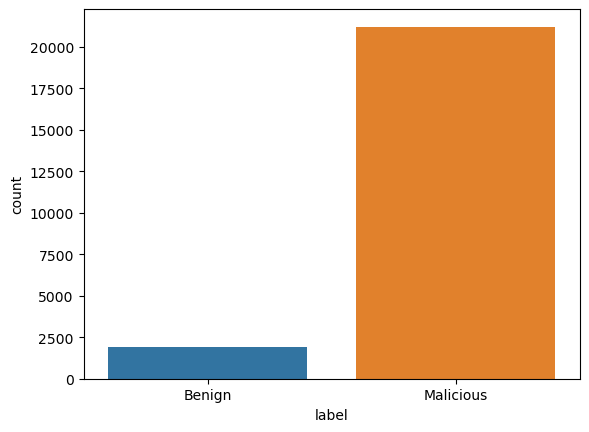

In [17]:
#plot target attribute on a count plot
sns.countplot(data=data_df, x="label")

- As we can see from these statistics, the target attribute is highly imbalanced.
- We will maintain the original distribution for now until we check the model performance. 
- Suitable techniques will be applied to re-balance the labels if we could't achieve an acceptable prediction accuracy. 

In [18]:
#initialize encoder with default parameters
target_le = LabelEncoder()

#fit the encoder to the target attribute
encoded_attribute = target_le.fit_transform(data_df["label"])

#replace target attribute with encoded values
data_df["label"] = encoded_attribute

#check mapped labels
dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))

{'Benign': 0, 'Malicious': 1}

### Handle outliers

In [20]:
#using describe() method to obtain some general statistics about the numerical features
numerical_features = ["duration", "orig_bytes",	"resp_bytes", "missed_bytes", "orig_pkts",	"orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,5321.000000,5.321000e+03,5321.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,22.806503,1.478868e+04,350.429431,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,722.522302,1.036441e+06,5378.262771,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,0.000497,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.075814,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,3.110974,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,3.153695,6.200000e+01,243.000000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,48976.819063,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


- From a quick reading of the statistical summary, we noticed many features with values that can be seen as outliers. 
- However, it's fairly difficult to confirm such values and their actual reasons without proper explanations by experts from the corresponding domain.
- For the sake of this demo, we well treat only "duration" as a feature with actual outliers as it's the only feature with significant amount of unique values.

<Axes: ylabel='duration'>

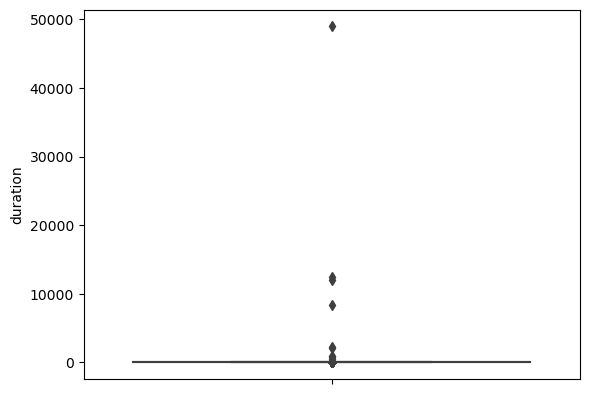

In [21]:
#plot "duration" feature on a boxplot
sns.boxplot(data=data_df, y="duration")

In [22]:
#replacing outliers using IQR (Inter-quartile Range)
outliers_columns = ['duration']
for col_name in outliers_columns:
    #calculate first and third quartiles
    q1, q3 = np.nanpercentile(data_df[col_name],[25,75])
    
    #calculate the inter-quartile range
    intr_qr = q3-q1

    #calculate lower and higher bounds
    iqr_min_val = q1-(1.5*intr_qr)
    iqr_max_val = q3+(1.5*intr_qr)
    print(f"(min,max) bounds for \"{col_name}\": ({iqr_min_val},{iqr_max_val})")
    
    #replace values that are less than min or larger then max with np.nan
    data_df.loc[data_df[col_name] < iqr_min_val, col_name] = np.nan
    data_df.loc[data_df[col_name] > iqr_max_val, col_name] = np.nan

(min,max) bounds for "duration": (0.4589924999999997,4.7705165)


In [23]:
#reevaluate the new distribution of values
data_df["duration"].describe()

count    3718.000000
mean        2.848130
std         0.806614
min         0.553685
25%         3.085004
50%         3.110717
75%         3.140398
max         4.723553
Name: duration, dtype: float64

### Encode IP addresses
Some columns contain IP addresses which need to be encoded into a corresponding numeric format

In [24]:
#function to encode an ip address using the IPv4/IPv6 manipulation library
def encode_ipv4(ip):
    return int(ipaddress.IPv4Address(ip))

In [25]:
#encoding ip features into numerical values
data_df["id.orig_h"] = data_df["id.orig_h"].apply(encode_ipv4)
data_df["id.resp_h"] = data_df["id.resp_h"].apply(encode_ipv4)

In [26]:
#check encoded ip addresses
ip_columns = ["id.orig_h","id.resp_h"]
for c in ip_columns:
    print(f"IP col ({c}) values: {data_df[c].unique()}")

IP col (id.orig_h) values: [3232235971 3232235777]
IP col (id.resp_h) values: [3119782379 2481415173 3278999753 1383150888 1359149245 1507709628
 3232235971 1359150816 3232235777 3266728169 1403518070 3563102355
 3247836863 1296985084  522144291 1843416203  633038892 1315727085
 1372076301 1359007963 2482712716 1359150624 3642641299 3116200853
  773615348 1585212350 1383150884  773614874 1507709998   83966075
 1347361135  631095852 1508837990 1507710594 1358024824 1354654157
 1760474084 1352111981 1111702952   16843009  842150453 2297672069
 2892123595 2449481872 1383150883 3272968657 2067517881 1247507960
 1195197076]


### Handle missing values

In [27]:
#check the number of null values in each column
data_df.isnull().sum().sort_values(ascending=False)

0
service          21298
duration         19427
resp_bytes       17824
orig_bytes       17824
missed_bytes         0
resp_ip_bytes        0
resp_pkts            0
orig_ip_bytes        0
orig_pkts            0
history              0
id.orig_h            0
conn_state           0
id.orig_p            0
proto                0
id.resp_p            0
id.resp_h            0
label                0
dtype: int64

<Axes: xlabel='0'>

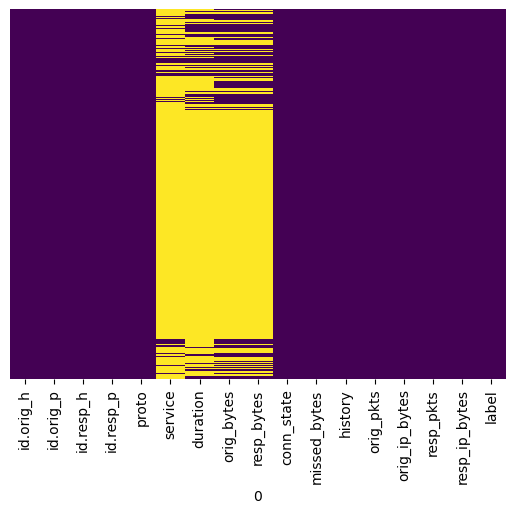

In [28]:
#check null values using heatmap
sns.heatmap(data=data_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

- There are only 4 columns with a lot of missing values, one categorical ("service) and three numerical (["duration","orig_bytes","resp_bytes"]).
- One possible approach is to entirely discard these columns from the dataset. Instead, we will try to impute their values to preserve any hidden information and check it we could obtain better prediction performance.

#### Impute missing values: categorical features

<Axes: xlabel='label', ylabel='count'>

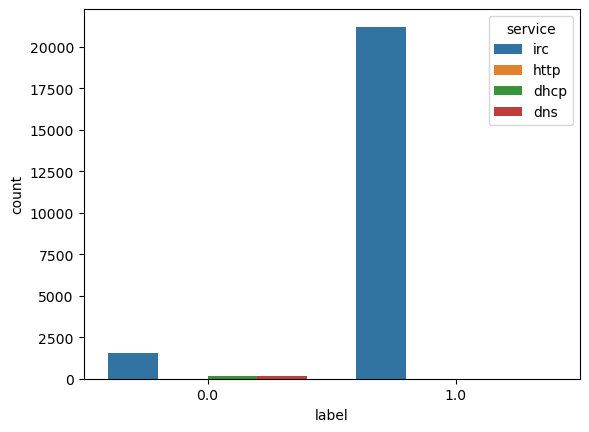

In [35]:
#check the relationship between "service" and target attribute
sns.countplot(data=data_df, x="label", hue="service")

- Due to this visualization, almost all *Malicious* observations belong to a specific service type ("irc"), while the other 3 types represent *Benign* samples.
- Accordingly, although "service" has high number of missing values, it has a strong correlation with the target attribute.
- The decision here is to keep "service" attribute while trying to impute missing values using another classifier. 

In [30]:
#select specific columns to be used for the classification, here we initially select the numerical attributes with no missing values.
srv_training_columns = ["id.orig_h","id.orig_p","id.resp_h","id.resp_p","missed_bytes","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes"] 

#split the rows into two datasets containing rows with/without "service".
data_df_with_service = data_df[data_df["service"].notna()]
data_df_no_service = data_df[data_df["service"].isna()]

#split the service dataset into dependent and independent features
srv_X = data_df_with_service[srv_training_columns]
srv_y = data_df_with_service["service"].values

#split into train/test subsets
srv_X_train, srv_X_test, srv_y_train, srv_y_test = train_test_split(srv_X, srv_y, test_size=0.2, random_state=0)

#create KNN estimator and fit it
srv_knn = KNeighborsClassifier(n_neighbors=3)
srv_knn.fit(srv_X_train, srv_y_train)

#predict missing values
srv_y_pred = srv_knn.predict(srv_X_test)

#check accuracy of predictions
srv_accuracy_test = accuracy_score(srv_y_test, srv_y_pred)
print(f"Prediction accuracy for 'service' is: {srv_accuracy_test}")
print("Classification report:")
print(classification_report(srv_y_test, srv_y_pred))

Prediction accuracy for 'service' is: 1.0
Classification report:
              precision    recall  f1-score   support

         dns       1.00      1.00      1.00        41
        http       1.00      1.00      1.00         5
         irc       1.00      1.00      1.00       324

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



The classification model achieved an accuracy of 1, which means all samples in the test subset were correctly predicted. Now we can use this model to predict missing "service" fields.

In [31]:
#predict "service" for missing values
srv_predictions = srv_knn.predict(data_df_no_service[srv_training_columns])

#update the original data set with predicted "service" values
data_df.loc[data_df["service"].isna(), "service"] = srv_predictions

#### Impute missing values: numerical features

In [32]:
#to preserve hidden correlations with other features in the dataset, we will use a KNN imputer to estimate the missing values based on relationships wit other numerical features.
numerical_features = data_df.select_dtypes(include="number").columns
knn_imputer = KNNImputer()
data_df_after_imputing = knn_imputer.fit_transform(data_df[numerical_features])

In [33]:
#update original data set to fill with imputed values
data_df[numerical_features] = data_df_after_imputing

In [34]:
#confirm all missing values were successfully imputed
data_df.isnull().sum().sort_values(ascending=False)

0
id.orig_h        0
conn_state       0
resp_ip_bytes    0
resp_pkts        0
orig_ip_bytes    0
orig_pkts        0
history          0
missed_bytes     0
resp_bytes       0
id.orig_p        0
orig_bytes       0
duration         0
service          0
proto            0
id.resp_p        0
id.resp_h        0
label            0
dtype: int64

### Encode categorical features

In [36]:
#look for categorical features in the dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_h      23145 non-null  float64
 1   id.orig_p      23145 non-null  float64
 2   id.resp_h      23145 non-null  float64
 3   id.resp_p      23145 non-null  float64
 4   proto          23145 non-null  object 
 5   service        23145 non-null  object 
 6   duration       23145 non-null  float64
 7   orig_bytes     23145 non-null  float64
 8   resp_bytes     23145 non-null  float64
 9   conn_state     23145 non-null  object 
 10  missed_bytes   23145 non-null  float64
 11  history        23145 non-null  object 
 12  orig_pkts      23145 non-null  float64
 13  orig_ip_bytes  23145 non-null  float64
 14  resp_pkts      23145 non-null  float64
 15  resp_ip_bytes  23145 non-null  float64
 16  label          23145 non-null  float64
dtypes: float64(13), object(4)
memory usage: 3.0+ MB


- Since all categorical features don't imply an ordered relationship between their values, they can be encoded using One-Hot Encoding.
- We need first to check features with rare values and map them to "other", in order to avoid sparse columns with statistically negligible impact and higher computational affect.

#### Encode categorical features: handle rare values

In [37]:
#check the number of unique values in each feature
categorical_features = ["proto","service","conn_state","history"]
for c in categorical_features:
    print(f"Column ({c}) has ({data_df[c].nunique()}) distinct values.")

Column (proto) has (2) distinct values.
Column (service) has (4) distinct values.
Column (conn_state) has (6) distinct values.
Column (history) has (26) distinct values.


In [38]:
#check values of "history" because it has too many unique values.hasattr
history_val_counts = data_df["history"].value_counts()
history_val_counts

C               14252
S                5417
ShAdDaf          1477
D                 978
Dd                836
ShAdDaft          102
ShAdfDr            48
CCCC                6
ShADadtcfF          3
ShADadttcfF         3
ShAdDatfr           2
CCC                 2
ShADadf             2
ShDadAf             2
ShAfdtDr            2
ShADacdtfF          2
ShADadtctfF         2
ShAdDatf            1
ShADadttfF          1
ShAdD               1
ShADadtctfFR        1
ShAdDfr             1
ShAD                1
DdAtaFf             1
ShADad              1
ShAdDa              1
Name: history, dtype: int64

In [39]:
#map values to their frequencies
history_freq_map = data_df["history"].map(history_val_counts)

#replace low frequent values in "history" with "Other" using the corresponding frequency map
data_df["history"] = data_df["history"].mask(history_freq_map < 10, "Other")

#check "history" values after mapping
data_df["history"].value_counts()

C           14252
S            5417
ShAdDaf      1477
D             978
Dd            836
ShAdDaft      102
ShAdfDr        48
Other          35
Name: history, dtype: int64

#### Encode categorical features: apply One-Hot Encoder

In [40]:
#initialize the encoder with its default parameters
ohe = OneHotEncoder()

#fit the encoder to categorical features in the dataset
encoded_features = ohe.fit_transform(data_df[categorical_features])

#create a dataframe of encoded features
encoded_features_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out())

#check the results of encoding
encoded_features_df

,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23141,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23142,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#merge encoded features with the dataset and drop original columns
data_df = pd.concat([data_df, encoded_features_df], axis=1).drop(categorical_features, axis=1)

### Validate the processed dataset

In [44]:
#check the final version of the dataset
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,3.232236e+09,41040.0,3.119782e+09,80.0,3.139211,0.0,0.0,0.0,3.0,180.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3.232236e+09,41040.0,3.119782e+09,80.0,3.152487,0.0,0.0,0.0,1.0,60.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.232236e+09,41040.0,3.119782e+09,80.0,3.152487,0.0,0.0,0.0,1.0,60.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.232236e+09,41040.0,3.119782e+09,80.0,1.477656,149.0,128252.0,2896.0,94.0,5525.0,96.0,139044.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.232236e+09,41042.0,3.119782e+09,80.0,3.147116,0.0,0.0,0.0,3.0,180.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
#check not null values and attribute types
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id.orig_h         23145 non-null  float64
 1   id.orig_p         23145 non-null  float64
 2   id.resp_h         23145 non-null  float64
 3   id.resp_p         23145 non-null  float64
 4   duration          23145 non-null  float64
 5   orig_bytes        23145 non-null  float64
 6   resp_bytes        23145 non-null  float64
 7   missed_bytes      23145 non-null  float64
 8   orig_pkts         23145 non-null  float64
 9   orig_ip_bytes     23145 non-null  float64
 10  resp_pkts         23145 non-null  float64
 11  resp_ip_bytes     23145 non-null  float64
 12  label             23145 non-null  float64
 13  proto_tcp         23145 non-null  float64
 14  proto_udp         23145 non-null  float64
 15  service_dhcp      23145 non-null  float64
 16  service_dns       23145 non-null  float6